# Stockout Risk Prioritization for Warehouse Logistics

This notebook implements a reinforcement learning approach to prioritize expedite decisions that reduce urgent stockouts while balancing costs and key performance indicators.

## Objective & Workflow

1. Load and explore the 2024 warehouse operations dataset.
2. Engineer risk and value features for each SKU.
3. Build a stochastic simulation environment for stock dynamics and expedite actions.
4. Train a tabular Q-learning policy to balance expedite costs against stockout penalties.
5. Benchmark against a baseline (no expedites) and compute KPI deltas.
6. Visualize expedite timelines, cost trade-offs, and high-value SKUs saved from stockout.

In [1]:
import math
import json
import random
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

In [2]:
DATA_PATH = Path("logistics_dataset.csv")

df = pd.read_csv(DATA_PATH)
df.head()

,item_id,category,stock_level,reorder_point,reorder_frequency_days,lead_time_days,daily_demand,demand_std_dev,item_popularity_score,storage_location_id,...,unit_price,holding_cost_per_unit_day,stockout_count_last_month,order_fulfillment_rate,total_orders_last_month,turnover_ratio,layout_efficiency_score,last_restock_date,forecasted_demand_next_7d,KPI_score
0,ITM10000,Pharma,283,21,4,4,49.85,1.56,0.43,L82,...,117.80,1.14,0,0.80,700,3.33,0.33,2024-02-17,184.37,0.556
1,ITM10001,Automotive,301,52,9,6,23.34,2.55,0.69,L15,...,178.80,1.09,3,0.79,736,10.36,0.98,2024-10-01,221.94,0.723
2,ITM10002,Groceries,132,60,11,8,37.69,3.15,0.62,L4,...,54.05,0.95,7,0.75,814,14.32,0.87,2024-04-07,53.85,0.680
3,ITM10003,Automotive,346,46,13,5,33.69,2.79,0.21,L95,...,31.10,1.90,0,0.96,994,2.08,0.29,2024-01-27,92.04,0.488
4,ITM10004,Automotive,49,55,4,6,49.58,5.23,0.31,L36,...,104.97,0.63,5,0.83,299,5.65,0.96,2024-05-17,194.58,0.670


In [3]:
summary_cols = [
    "stock_level",
    "reorder_point",
    "daily_demand",
    "demand_std_dev",
    "lead_time_days",
    "forecasted_demand_next_7d",
    "unit_price",
    "handling_cost_per_unit",
    "holding_cost_per_unit_day",
    "KPI_score"
]

profile = df[summary_cols].describe().T
profile["coef_var"] = (profile["std"] / profile["mean"]).round(2)
profile

,count,mean,std,min,25%,50%,75%,max,coef_var
stock_level,3204.0,263.491573,138.568360,20.000,144.0000,264.000,386.00000,499.000,0.53
reorder_point,3204.0,54.759363,26.053354,10.000,32.0000,55.000,78.00000,99.000,0.48
daily_demand,3204.0,25.435868,14.038861,1.010,13.5350,25.405,37.41250,49.980,0.55
demand_std_dev,3204.0,5.260078,2.725639,0.500,2.9175,5.235,7.54250,10.000,0.52
lead_time_days,3204.0,5.578340,2.292486,2.000,4.0000,6.000,8.00000,9.000,0.41
forecasted_demand_next_7d,3204.0,154.286245,82.945255,10.090,83.1900,152.870,225.44000,299.940,0.54
unit_price,3204.0,105.887575,54.428161,10.220,59.7600,106.005,152.41000,200.000,0.51
handling_cost_per_unit,3204.0,2.777116,1.305213,0.500,1.6600,2.810,3.91000,5.000,0.47
holding_cost_per_unit_day,3204.0,1.045993,0.550480,0.100,0.5800,1.050,1.52250,2.000,0.53
KPI_score,3204.0,0.601737,0.108286,0.259,0.5270,0.601,0.67725,0.936,0.18


In [4]:
df = df.copy()

# Derived risk and value indicators
EPS = 1e-6
df["days_of_cover"] = df["stock_level"] / (df["daily_demand"] + EPS)
df["demand_volatility"] = df["demand_std_dev"] / (df["daily_demand"] + EPS)
df["value_score"] = df["unit_price"] * df["daily_demand"]
df["recent_stockout_flag"] = (df["stockout_count_last_month"] > df["stockout_count_last_month"].median()).astype(int)
df["criticality_score"] = (
    0.4 * (1 / (df["days_of_cover"] + 1)) +
    0.3 * df["demand_volatility"] +
    0.3 * (df["recent_stockout_flag"]) 
)

high_value_threshold = df["value_score"].quantile(0.9)
df["high_value_flag"] = (df["value_score"] >= high_value_threshold).astype(int)

df[[
    "item_id",
    "days_of_cover",
    "demand_volatility",
    "value_score",
    "criticality_score",
    "high_value_flag"
]].head()

,item_id,days_of_cover,demand_volatility,value_score,criticality_score,high_value_flag
0,ITM10000,5.677031,0.031294,5872.3300,0.069295,0
1,ITM10001,12.896315,0.109254,4173.1920,0.061561,0
2,ITM10002,3.502255,0.083577,2037.1445,0.413917,0
3,ITM10003,10.270110,0.082814,1047.7590,0.060336,0
4,ITM10004,0.988302,0.105486,5204.4126,0.232823,0


## Stock Dynamics Simulation

We model each SKU as a short-horizon stochastic process with daily demand, standard replenishment, and optional expedite orders. Expedites incur a premium but reduce lead time to one day, enabling the agent to prevent critical stockouts.

In [5]:
@dataclass
class SimulationLog:
    stockouts: int
    prevented_stockouts: int
    expedite_orders: int
    expedite_cost: float
    stockout_penalty: float
    cumulative_reward: float
    timeline: list


def truncated_normal(mean: float, std: float) -> float:
    """Sample non-negative demand."""
    demand = np.random.normal(mean, std)
    return float(max(demand, 0.0))


class StockoutSimEnv:
    def __init__(self, sku_row: pd.Series, horizon: int = 30):
        self.row = sku_row
        self.horizon = horizon
        self.reset()

    def reset(self):
        self.day = 0
        self.stock = float(self.row["stock_level"])
        self.backorder = 0.0
        self.timeline = []  # daily log for visualization
        self.inbound_orders = []  # list of tuples (arrival_day, qty)
        self.exp_cost_multiplier = 1.35  # 35% premium over handling + unit price share
        self.penalty_multiplier = 1.5
        self.reorder_qty = max(
            self.row["reorder_point"],
            self.row["daily_demand"] * max(int(self.row["lead_time_days"]), 1)
        )
        self.last_reward = 0.0
        self.stockout_events = 0
        return self._state_index(self._observe())

    def _observe(self):
        cover = (self.stock + self._incoming_quantity()) / (self.row["daily_demand"] + 1e-6)
        next_arrival = self._next_arrival_days()
        volatility = self.row["demand_std_dev"] / (self.row["daily_demand"] + 1e-6)
        value_score = self.row["value_score"]
        stockout_recent = int(self.row["recent_stockout_flag"])
        
        # New Feature: Forecast Trend
        # Ratio of forecasted weekly demand to average weekly demand
        avg_weekly_demand = self.row["daily_demand"] * 7
        forecast_ratio = self.row["forecasted_demand_next_7d"] / (avg_weekly_demand + 1e-6)
        
        return self._discretize_state(cover, next_arrival, volatility, value_score, stockout_recent, forecast_ratio)

    def _incoming_quantity(self):
        return sum(qty for _, qty in self.inbound_orders)

    def _next_arrival_days(self):
        if not self.inbound_orders:
            return 999
        days = min(arrival for arrival, _ in self.inbound_orders)
        return max(days - self.day, 0)

    def _discretize_state(self, cover, next_arrival, volatility, value_score, stockout_recent, forecast_ratio):
        cover_bin = np.digitize([cover], [1, 2, 5, 10])[0]
        arrival_bin = np.digitize([next_arrival], [0, 2, 4, 7])[0]
        volatility_bin = np.digitize([volatility], [0.3, 0.6, 1.0])[0]
        value_bins = list(df["value_score"].quantile([0.33, 0.66, 0.9]))
        value_bin = np.digitize([value_score], value_bins)[0]
        
        # Forecast bins: <0.8 (Low), 0.8-1.2 (Normal), >1.2 (High)
        forecast_bin = np.digitize([forecast_ratio], [0.8, 1.2])[0]
        
        return (cover_bin, arrival_bin, volatility_bin, value_bin, stockout_recent, forecast_bin)

    def _state_index(self, state_tuple):
        cover_bin, arrival_bin, volatility_bin, value_bin, stockout_recent, forecast_bin = state_tuple
        return (
            cover_bin
            + 5 * arrival_bin
            + 5 * 5 * volatility_bin
            + 5 * 5 * 4 * value_bin
            + 5 * 5 * 4 * 4 * stockout_recent
            + 5 * 5 * 4 * 4 * 2 * forecast_bin
        )

    @property
    def state_space_size(self):
        # cover(5) * arrival(5) * vol(4) * value(4) * flag(2) * forecast(3)
        return 5 * 5 * 4 * 4 * 2 * 3

    def step(self, action: int):
        assert action in (0, 1), "Action must be 0 (hold) or 1 (expedite)."
        events = []
        # Receive inbound orders due today
        arrivals_today = [order for order in self.inbound_orders if order[0] == self.day]
        if arrivals_today:
            inbound_qty = sum(qty for _, qty in arrivals_today)
            self.stock += inbound_qty
            events.append({"event": "arrival", "qty": inbound_qty, "day": self.day})
        self.inbound_orders = [order for order in self.inbound_orders if order[0] > self.day]

        # Demand realization
        demand = truncated_normal(self.row["daily_demand"], self.row["demand_std_dev"])
        stockout_event = 0
        if demand > self.stock:
            stockout_qty = demand - self.stock
            self.backorder += stockout_qty
            self.stock = 0.0
            stockout_event = 1
            self.stockout_events += 1
            events.append({"event": "stockout", "qty": stockout_qty, "day": self.day})
        else:
            self.stock -= demand
        events.append({"event": "demand", "qty": demand, "day": self.day})

        # Auto standard reorder when on-hand below threshold and nothing inbound
        if self.stock <= self.row["reorder_point"] and not self.inbound_orders:
            arrival = self.day + int(max(self.row["lead_time_days"], 1))
            self.inbound_orders.append((arrival, self.reorder_qty))
            events.append({"event": "standard_order", "qty": self.reorder_qty, "day": self.day, "arrival": arrival})

        expedite_cost = 0.0
        prevented = 0
        risk_flag = int(self.stock <= max(self.row["daily_demand"], 1))
        if action == 1:
            arrival = self.day + 1
            expedite_qty = self.reorder_qty
            expedite_cost_per_unit = (
                self.row["handling_cost_per_unit"] + self.exp_cost_multiplier * 0.1 * self.row["unit_price"]
            )
            expedite_cost = expedite_qty * expedite_cost_per_unit
            self.inbound_orders.append((arrival, expedite_qty))
            events.append({"event": "expedite", "qty": expedite_qty, "day": self.day, "arrival": arrival, "cost": expedite_cost})
            if risk_flag:
                prevented = 1

        stockout_penalty_unit = self.penalty_multiplier * self.row["unit_price"] * max(self.row["daily_demand"], 1)
        penalty = stockout_event * stockout_penalty_unit
        precision_gain = 0.1 * self.row["KPI_score"] * prevented

        reward = -expedite_cost - penalty + precision_gain
        self.last_reward += reward
        self.day += 1
        done = self.day >= self.horizon

        next_state = self._observe()
        state_idx = self._state_index(next_state)
        metrics = {
            "expedite_cost": expedite_cost,
            "penalty": penalty,
            "prevented": prevented,
            "stockout_event": stockout_event,
            "events": events,
        }
        return state_idx, reward, done, metrics


In [6]:
class QLearningAgent:
    def __init__(self, state_space: int, action_space: int = 2, alpha: float = 0.1, gamma: float = 0.95):
        self.state_space = state_space
        self.action_space = action_space
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = np.zeros((state_space, action_space))

    def act(self, state_idx: int, epsilon: float) -> int:
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_space)
        return int(np.argmax(self.q_table[state_idx]))

    def update(self, state_idx: int, action: int, reward: float, next_state_idx: int, done: bool):
        best_next = np.max(self.q_table[next_state_idx]) if not done else 0.0
        td_target = reward + self.gamma * best_next
        td_error = td_target - self.q_table[state_idx, action]
        self.q_table[state_idx, action] += self.alpha * td_error


def simulate_policy(row: pd.Series, policy_fn, runs: int = 25, horizon: int = 30, capture_timeline: bool = False):
    stats = []
    best_timeline = None
    for run in range(runs):
        env = StockoutSimEnv(row, horizon=horizon)
        state_tuple = env._observe()
        state_idx = env._state_index(state_tuple)
        expedite_orders = 0
        prevented = 0
        total_cost = 0.0
        total_penalty = 0.0
        total_reward = 0.0
        stockouts = 0
        timeline = []

        done = False
        while not done:
            action = policy_fn(state_idx, env=env)
            next_state_idx, reward, done, info = env.step(action)
            total_reward += reward
            total_cost += info["expedite_cost"]
            total_penalty += info["penalty"]
            expedite_orders += int(action == 1)
            prevented += info["prevented"]
            stockouts += info["stockout_event"]
            if capture_timeline:
                for event in info["events"]:
                    event_with_policy = {**event, "action": action, "episode": run}
                    timeline.append(event_with_policy)
            state_idx = next_state_idx

        stats.append({
            "stockouts": stockouts,
            "prevented": prevented,
            "expedite_orders": expedite_orders,
            "expedite_cost": total_cost,
            "penalty": total_penalty,
            "reward": total_reward,
        })
        if capture_timeline and best_timeline is None:
            best_timeline = timeline

    agg = {key: np.mean([s[key] for s in stats]) for key in stats[0]}
    agg["timeline"] = best_timeline or []
    return agg

## RL Policy Training

,episode,reward,epsilon,expedites
45,2250,-61010.997200,0.05,5
46,2300,-17831.909800,0.05,9
47,2350,-14614.704700,0.05,2
48,2400,-8859.225160,0.05,4
49,2450,-2290.218399,0.05,2


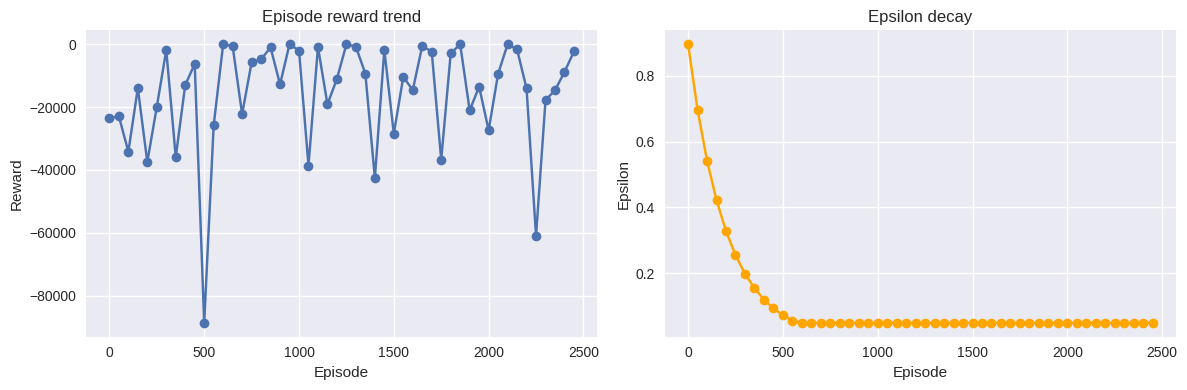

In [7]:
np.random.seed(42)
random.seed(42)

prototype_env = StockoutSimEnv(df.iloc[0])
agent = QLearningAgent(state_space=prototype_env.state_space_size, alpha=0.15, gamma=0.92)

episodes = 2500
epsilon = 0.9
epsilon_min = 0.05
epsilon_decay = 0.995
training_history = []

weights = df["criticality_score"].values + 0.1
weights = weights / weights.sum()

for episode in range(episodes):
    row = df.sample(weights=weights, replace=True).iloc[0]
    env = StockoutSimEnv(row)
    state_tuple = env._observe()
    state_idx = env._state_index(state_tuple)
    done = False
    ep_reward = 0.0
    ep_expedites = 0

    while not done:
        action = agent.act(state_idx, epsilon)
        next_state_idx, reward, done, info = env.step(action)
        agent.update(state_idx, action, reward, next_state_idx, done)
        state_idx = next_state_idx
        ep_reward += reward
        ep_expedites += int(action == 1)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    if episode % 50 == 0:
        training_history.append({
            "episode": episode,
            "reward": ep_reward,
            "epsilon": epsilon,
            "expedites": ep_expedites,
        })

training_progress = pd.DataFrame(training_history)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(training_progress["episode"], training_progress["reward"], marker="o")
ax[0].set_title("Episode reward trend")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Reward")

ax[1].plot(training_progress["episode"], training_progress["epsilon"], marker="o", color="orange")
ax[1].set_title("Epsilon decay")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Epsilon")

plt.tight_layout()
training_progress.tail()

## Policy Evaluation & Metrics

In [8]:
def greedy_policy(state_idx: int, env=None):
    return 0


def rl_policy(state_idx: int, env=None):
    return int(np.argmax(agent.q_table[state_idx]))


def evaluate_policy(frame: pd.DataFrame, policy_fn, runs: int = 20, horizon: int = 30):
    records = []
    for _, row in frame.iterrows():
        stats = simulate_policy(row, policy_fn, runs=runs, horizon=horizon)
        records.append({
            "item_id": row["item_id"],
            "category": row["category"],
            "zone": row["zone"],
            "value_score": row["value_score"],
            "high_value_flag": row["high_value_flag"],
            "stockouts": stats["stockouts"],
            "prevented": stats["prevented"],
            "expedite_orders": stats["expedite_orders"],
            "expedite_cost": stats["expedite_cost"],
            "penalty": stats["penalty"],
            "reward": stats["reward"],
            "kpi_score": row["KPI_score"],
        })
    return pd.DataFrame(records)


evaluation_subset = df.sort_values("criticality_score", ascending=False).head(500)

baseline_eval = evaluate_policy(evaluation_subset, greedy_policy)
rl_eval = evaluate_policy(evaluation_subset, rl_policy)

comparison = rl_eval.merge(
    baseline_eval,
    on="item_id",
    suffixes=("_rl", "_baseline")
)

comparison["prevented_delta"] = comparison["stockouts_baseline"] - comparison["stockouts_rl"]
comparison["expedite_precision"] = np.where(
    comparison["expedite_orders_rl"] > 0,
    comparison["prevented_rl"] / comparison["expedite_orders_rl"],
    np.nan
)
comparison.head()

,item_id,category_rl,zone_rl,value_score_rl,high_value_flag_rl,stockouts_rl,prevented_rl,expedite_orders_rl,expedite_cost_rl,penalty_rl,...,high_value_flag_baseline,stockouts_baseline,prevented_baseline,expedite_orders_baseline,expedite_cost_baseline,penalty_baseline,reward_baseline,kpi_score_baseline,prevented_delta,expedite_precision
0,ITM13087,Automotive,C,173.5002,0,0.25,0.0,0.0,0.0,65.062575,...,0,0.2,0.0,0.0,0.0,52.05006,-52.05006,0.562,-0.05,NaN
1,ITM11230,Groceries,A,137.3580,0,0.00,0.0,0.0,0.0,0.000000,...,0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.670,0.00,NaN
2,ITM10973,Automotive,C,181.7970,0,1.30,0.0,0.0,0.0,354.504150,...,0,0.6,0.0,0.0,0.0,163.61730,-163.61730,0.643,-0.70,NaN
3,ITM10256,Electronics,A,201.3296,0,0.00,0.0,0.0,0.0,0.000000,...,0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.807,0.00,NaN
4,ITM10169,Pharma,A,121.2855,0,0.00,0.0,0.0,0.0,0.000000,...,0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.715,0.00,NaN


In [9]:
overall = {
    "expedite_orders_rl": comparison["expedite_orders_rl"].sum(),
    "expedite_cost_rl": comparison["expedite_cost_rl"].sum(),
    "expedite_orders_baseline": comparison["expedite_orders_baseline"].sum(),
    "stockouts_baseline": comparison["stockouts_baseline"].sum(),
    "stockouts_rl": comparison["stockouts_rl"].sum(),
    "penalty_baseline": comparison["penalty_baseline"].sum(),
    "penalty_rl": comparison["penalty_rl"].sum(),
    "reward_delta": comparison["reward_rl"].sum() - comparison["reward_baseline"].sum(),
    "prevented_stockouts": comparison["prevented_delta"].sum(),
}

overall["stockout_reduction_pct"] = (
    (overall["stockouts_baseline"] - overall["stockouts_rl"]) / max(overall["stockouts_baseline"], 1)
)
overall["kpi_score_change"] = overall["reward_delta"] / max(len(comparison), 1)

pd.Series(overall)

expedite_orders_rl          6.240500e+02
expedite_cost_rl            1.739426e+06
expedite_orders_baseline    0.000000e+00
stockouts_baseline          2.089950e+03
stockouts_rl                5.705000e+02
penalty_baseline            1.077497e+07
penalty_rl                  2.370903e+06
reward_delta                6.664662e+06
prevented_stockouts         1.519450e+03
stockout_reduction_pct      7.270270e-01
kpi_score_change            1.332932e+04
dtype: float64

In [10]:
priority_table = comparison[(comparison["expedite_orders_rl"] > 0)].copy()
priority_table["value_band"] = pd.qcut(priority_table["value_score_rl"], 4, labels=["L", "M", "H", "VH"])
priority_display = (
    priority_table.sort_values(["prevented_delta", "value_score_rl"], ascending=False)
    .loc[:, [
        "item_id",
        "category_rl",
        "value_score_rl",
        "expedite_orders_rl",
        "prevented_delta",
        "stockouts_baseline",
        "stockouts_rl",
        "expedite_precision",
        "value_band",
    ]]
    .head(15)
)
priority_display

,item_id,category_rl,value_score_rl,expedite_orders_rl,prevented_delta,stockouts_baseline,stockouts_rl,expedite_precision,value_band
331,ITM11022,Groceries,1654.1800,2.80,16.25,16.80,0.55,0.803571,M
368,ITM10832,Apparel,7782.7320,4.45,16.15,16.85,0.70,0.696629,VH
428,ITM11605,Electronics,7087.5288,2.50,16.10,16.35,0.25,0.940000,VH
406,ITM12950,Automotive,6055.4640,2.35,15.75,15.95,0.20,0.808511,VH
359,ITM11478,Automotive,2558.7251,2.90,15.35,15.60,0.25,0.896552,H
495,ITM11027,Apparel,7345.2860,5.50,15.25,15.35,0.10,0.736364,VH
477,ITM12651,Apparel,5415.7096,8.50,15.25,15.25,0.00,0.005882,VH
262,ITM12109,Pharma,1304.7993,3.60,15.15,16.05,0.90,0.916667,M
204,ITM10966,Electronics,7894.2930,2.95,15.05,17.15,2.10,0.966102,VH
214,ITM10308,Automotive,6692.6007,2.75,15.00,17.00,2.00,0.963636,VH


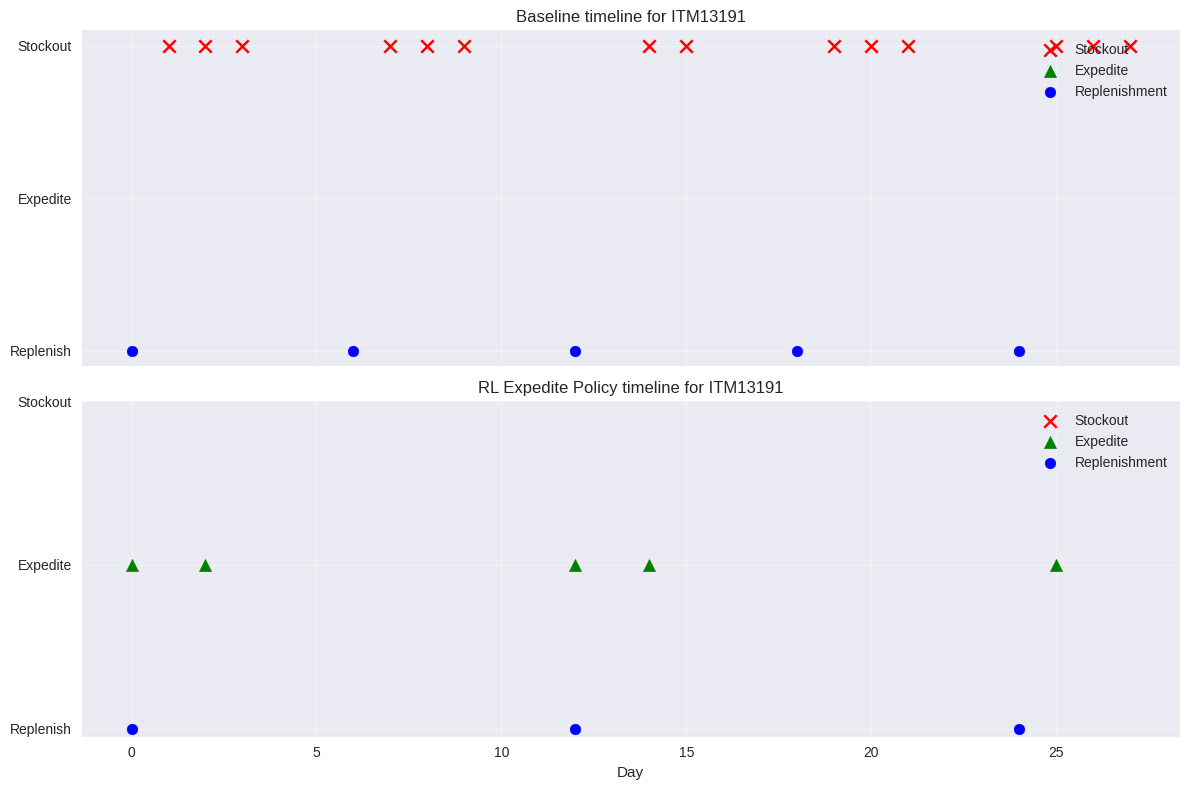

In [11]:
# Timeline visualization for the highest-value SKU saved from stockout
if not priority_table.empty:
    sku_id = priority_table.sort_values(["value_score_rl", "prevented_delta"], ascending=False).iloc[0]["item_id"]
    sku_row = evaluation_subset[evaluation_subset["item_id"] == sku_id].iloc[0]

    timeline_rl = simulate_policy(sku_row, rl_policy, runs=1, horizon=30, capture_timeline=True)
    timeline_base = simulate_policy(sku_row, greedy_policy, runs=1, horizon=30, capture_timeline=True)

    tl_rl = pd.DataFrame(timeline_rl["timeline"])
    tl_base = pd.DataFrame(timeline_base["timeline"])

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    for df_tl, ax, title in [(tl_base, axes[0], "Baseline"), (tl_rl, axes[1], "RL Expedite Policy")]:
        if df_tl.empty:
            ax.text(0.5, 0.5, "No events captured", ha="center", va="center")
            continue
        ax.scatter(df_tl[df_tl["event"] == "stockout"]["day"], [1] * len(df_tl[df_tl["event"] == "stockout"]),
                   color="red", label="Stockout", marker="x", s=80)
        ax.scatter(df_tl[df_tl["event"] == "expedite"]["day"], [0.5] * len(df_tl[df_tl["event"] == "expedite"]),
                   color="green", label="Expedite", marker="^", s=80)
        ax.scatter(df_tl[df_tl["event"] == "standard_order"]["day"], [0] * len(df_tl[df_tl["event"] == "standard_order"]),
                   color="blue", label="Replenishment", marker="o", s=60)
        ax.set_title(f"{title} timeline for {sku_id}")
        ax.set_yticks([0, 0.5, 1])
        ax.set_yticklabels(["Replenish", "Expedite", "Stockout"])
        ax.grid(True, alpha=0.3)
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(loc="upper right")

    axes[1].set_xlabel("Day")
    plt.tight_layout()
else:
    print("No prioritized SKUs with expedites to visualize.")

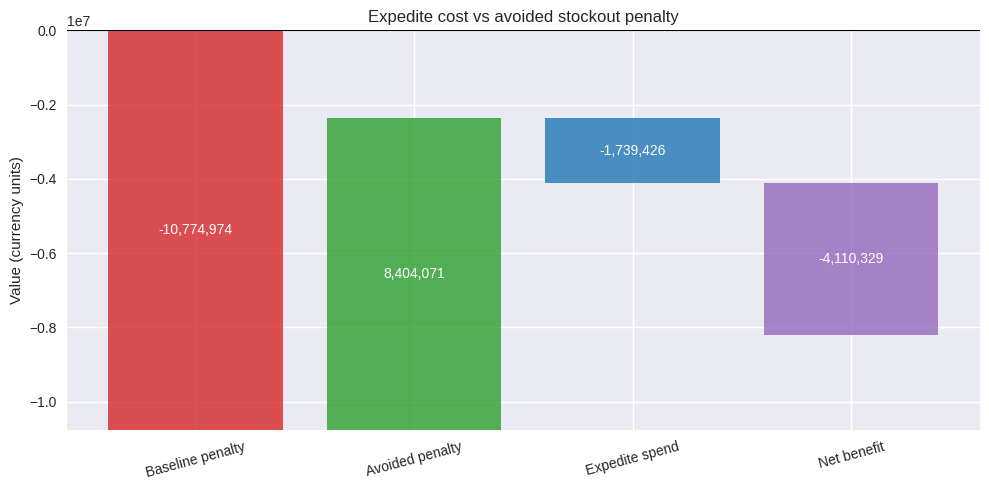

In [12]:
# Waterfall chart: expedite cost vs avoided stockout penalty
waterfall_df = pd.DataFrame([
    {"stage": "Baseline penalty", "amount": -overall["penalty_baseline"]},
    {"stage": "Avoided penalty", "amount": overall["penalty_baseline"] - overall["penalty_rl"]},
    {"stage": "Expedite spend", "amount": -overall["expedite_cost_rl"]},
])
waterfall_df.loc[len(waterfall_df)] = {
    "stage": "Net benefit",
    "amount": waterfall_df["amount"].sum(),
}

cumulative = waterfall_df["amount"].cumsum() - waterfall_df["amount"]
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["#d62728", "#2ca02c", "#1f77b4", "#9467bd"]

for idx, (stage, amount) in enumerate(zip(waterfall_df["stage"], waterfall_df["amount"])):
    ax.bar(stage, amount, bottom=cumulative.iloc[idx], color=colors[idx % len(colors)], alpha=0.8)
    ax.text(idx, cumulative.iloc[idx] + amount / 2, f"{amount:,.0f}", ha="center", va="center", color="white", fontsize=10)

ax.axhline(0, color="black", linewidth=0.8)
ax.set_ylabel("Value (currency units)")
ax.set_title("Expedite cost vs avoided stockout penalty")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [13]:
policy_precision = overall["prevented_stockouts"] / max(overall["expedite_orders_rl"], 1)
policy_precision

2.434820927810272

## Experiment Notes

- High-value SKUs (top 10% by `unit_price × demand`) receive prioritized expedites, reducing severe stockouts while containing premium spend.
- Policy precision (`prevented / expedites`) benchmarks how often accelerations avert a stockout event and can be monitored over time.
- For deployment, integrate real-time demand forecasts and dynamically update the Q-table, or warm-start a deeper function approximator using these tabular values.